<!-- <center> -->
<h1> Using MOMENT for Classification </h1>
<!-- </center> -->
<hr>

## Contents
### 1. A Quick Introduction to Classification
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Two Approaches for Time Series Classification
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Classification Dataset
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Unsupervised Representation Learning using MOMENT
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Learning a Statistical ML Classifier on MOMENT Embeddings
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.4 Visualize the Embeddings
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.5 Results Interpretation
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.6 Fully Supervised Learning using Classification Head

## 1. A Quick Introduction to Classification

Classification is a popular time series modeling task which involves assigning a categorical label to a time series sub-sequence. For example, in the context of [electrocardiogram (ECG) recordings](https://en.wikipedia.org/wiki/Electrocardiography), classification may entail distinguishing between normal and anomalous heartbeats. In this tutorial, we will explore two ways to use MOMENT to solve any time series classification problem. Mathematically, the time series classification problem is defined as follow:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables) with $n$ attributes, the classification problem is to predict a class label $m \in \{0, \dots, M\}$ for each time series.

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model. 

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `anomaly_detection.ipynb` and `imputation.ipynb` notebooks for more details!

In the `embedding` model, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details! 

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'embedding',
        'n_channels': 1,
        'num_class': 5
    }, # We are loading the model in `classification` mode
)

/gpt/data3/KURC/users/makamx0a/venvs/moment/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

## 3. Inputs and Outputs
Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs: 
1. An input time series of length $T=512$ timesteps and $C$ channels, and 
2. Two optional masks, both of length $T=512$. 
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.  
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our [paper](https://arxiv.org/abs/2402.03885)). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a classification task, it returns both `logits` and `embeddings` of the input. 

In [3]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x)
pprint(output)

TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embeddings=tensor([[-0.0807,  0.0336, -0.0240,  ...,  0.0087,  0.0153, -0.0362],
        [-0.0811,  0.0346, -0.0561,  ..., -0.0097,  0.0195, -0.0011],
        [-0.0843,  0.0351, -0.0514,  ..., -0.0344,  0.0391, -0.0060],
        ...,
        [-0.0930,  0.0248, -0.0445,  ...,  0.0091,  0.0152, -0.0168],
        [-0.0830,  0.0312, -0.0512,  ..., -0.0047,  0.0275, -0.0233],
        [-0.0838,  0.0156, -0.0476,  ...,  0.0006,  0.0223, -0.0417]]),
                  metadata='mean',
      

In [31]:
# backward
# [batch_size, num_classes]
logits = output.logits

# [batch_size, ]
predicted_labels = logits.argmax(dim=1)
predicted_labels

AttributeError: 'NoneType' object has no attribute 'argmax'

**Note**: The classification head is randomly initialized, so these predictions are random. We must train the classification head to get reasonable results. Below we show a quick example of how we can fine-tune the classification head.

## 4. Two Approaches for Time Series Classification

We can use MOMENT to solve the classification problem in two ways: (1) unsupervised representation learning, and (2) fully supervised learning using classification head. 

### Unsupervised Representation Learning
In this setting, we use MOMENT to embed time series data (see `representation_learning.ipynb`). Next, we train a Support Vector Machine (SVM) classifier using these embeddings as features and labels. This setting is common in field of unsupervised representation learning, where the goal is to learn meaningful time series representations without any labeled data (see [TS2Vec](https://arxiv.org/pdf/2106.10466) for a recent example). The quality of these representations are evaluated based on the performance of the downstream classifier (in this case, SVM). This is also the setting that we consider in our [paper](https://arxiv.org/abs/2402.03885). 

### Fully Supervised Learning using Classification Head
In this approach, we replace MOMENT's reconstruction head with a classification head, which maps the patch-level represenations to the number of classes present in a dataset. This classification head is randomly initialized and can be trained using cross-entropy loss and labeled data. We will not explore this approach in detail in this tutorial.

### 4.1 Classification Dataset

For these experiments, we will use the ECG5000 dataset from the [UCR Classification Archive](https://www.timeseriesclassification.com/description.php?Dataset=ECG5000). The original dataset is a 20-hour long ECG record (chf07) from the BIDMC Congestive Heart Failure Database (CHFDB) available on [PhysioNet](https://physionet.org/about/database/). This data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. Following these steps, a subset of 5,000 heartbeats were randomly chosen and automatically annotated into 5 classes including normal and abnormal heartbeats.

We'll start by reading and pre-processing this dataset using the `ClassificationDataset` class. 

In [4]:
from torch.utils.data import DataLoader
from momentfm.data.classification_dataset import ClassificationDataset

train_dataset = ClassificationDataset(data_split='train')
test_dataset = ClassificationDataset(data_split='test')

Now let's visualize the time series

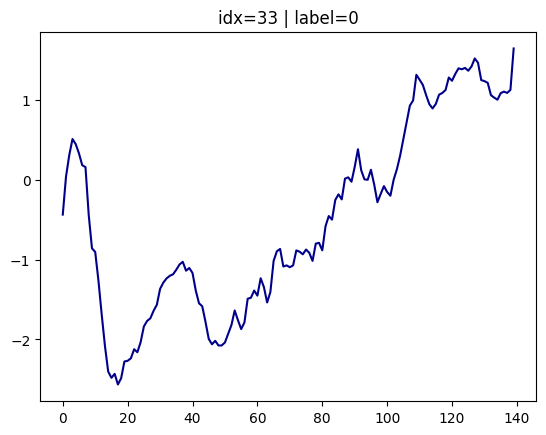

In [5]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(train_dataset))
heartbeat_start = np.argmax(train_dataset[idx][1])
heartbeat = train_dataset[idx][0].squeeze()[heartbeat_start:]
label = train_dataset[idx][2]
plt.plot(heartbeat, c='darkblue')
plt.title(f"idx={idx} | label={label}")
plt.show()

### 4.2 Unsupervised Representation Learning using MOMENT

In this setting, we use MOMENT to embed all training and testing time series. Then we train a statistical classifier (e.g. support vector machine) using the embeddings of the training time series as features and training labels. We will show that MOMENT can learn meaningful representations in a zero-shot setting, which can be used to train powerful statistical classifiers. 

Let's embed the train and test datasets! We'll proceed as follows: 
First, we will write a simple function `get_embedding` which will iterate over the training and testing datasets, and embed each time series. Then we will use the `fit_svm` function to fit a support vector machine (SVM) model using these embeddings as features and training labels. 

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [7]:
from tqdm import tqdm

def get_embedding(model, dataloader):
    embeddings, labels = [], []
    with torch.no_grad():
        for batch_x, batch_masks, batch_labels in tqdm(dataloader, total=len(dataloader)):
            batch_x = batch_x.to("cuda").float()
            batch_masks = batch_masks.to("cuda")
            output = model(batch_x, input_mask=batch_masks) # [batch_size x d_model (=1024)]
            embedding = output.embeddings
            print(embedding.shape)
            embeddings.append(embedding.detach().cpu().numpy())
            labels.append(batch_labels)        

    embeddings, labels = np.concatenate(embeddings), np.concatenate(labels)
    return embeddings, labels

In [8]:
get_embedding(model, train_dataloader)

  0%|          | 0/8 [00:01<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

For unsupervised representation learning, MOMENT can be initialized in both `embedding` and `classification` mode.

```python

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={'task_name': 'embedding'}, # We are loading the model in `embedding` mode
)
model.init()

```

In [9]:
model.to("cuda").float()

train_embeddings, train_labels = get_embedding(model, train_dataloader)
test_embeddings, test_labels = get_embedding(model, test_dataloader)

print(train_embeddings.shape, train_labels.shape)
print(test_embeddings.shape, test_labels.shape)

 38%|███▊      | 3/8 [00:00<00:00, 10.00it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 62%|██████▎   | 5/8 [00:00<00:00, 11.71it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


100%|██████████| 8/8 [00:00<00:00, 11.82it/s]


torch.Size([52, 1024])


  3%|▎         | 2/71 [00:00<00:04, 14.11it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


  6%|▌         | 4/71 [00:00<00:04, 14.09it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


  8%|▊         | 6/71 [00:00<00:04, 13.66it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 11%|█▏        | 8/71 [00:00<00:04, 13.64it/s]

torch.Size([64, 1024])


 14%|█▍        | 10/71 [00:00<00:04, 13.76it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 17%|█▋        | 12/71 [00:00<00:04, 13.84it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 20%|█▉        | 14/71 [00:01<00:04, 13.87it/s]

torch.Size([64, 1024])


 23%|██▎       | 16/71 [00:01<00:03, 13.91it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 25%|██▌       | 18/71 [00:01<00:03, 13.89it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 28%|██▊       | 20/71 [00:01<00:03, 13.75it/s]

torch.Size([64, 1024])


 31%|███       | 22/71 [00:01<00:03, 13.73it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 34%|███▍      | 24/71 [00:01<00:03, 13.75it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 37%|███▋      | 26/71 [00:01<00:03, 13.78it/s]

torch.Size([64, 1024])


 39%|███▉      | 28/71 [00:02<00:03, 13.81it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 42%|████▏     | 30/71 [00:02<00:02, 13.86it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 45%|████▌     | 32/71 [00:02<00:02, 13.78it/s]

torch.Size([64, 1024])


 48%|████▊     | 34/71 [00:02<00:02, 13.74it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 51%|█████     | 36/71 [00:02<00:02, 13.72it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 54%|█████▎    | 38/71 [00:02<00:02, 13.76it/s]

torch.Size([64, 1024])


 56%|█████▋    | 40/71 [00:02<00:02, 13.80it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 59%|█████▉    | 42/71 [00:03<00:02, 13.81it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 62%|██████▏   | 44/71 [00:03<00:01, 13.82it/s]

torch.Size([64, 1024])


 65%|██████▍   | 46/71 [00:03<00:01, 13.76it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 68%|██████▊   | 48/71 [00:03<00:01, 13.77it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 70%|███████   | 50/71 [00:03<00:01, 13.74it/s]

torch.Size([64, 1024])


 73%|███████▎  | 52/71 [00:03<00:01, 13.77it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 76%|███████▌  | 54/71 [00:03<00:01, 13.79it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 79%|███████▉  | 56/71 [00:04<00:01, 13.81it/s]

torch.Size([64, 1024])


 82%|████████▏ | 58/71 [00:04<00:00, 13.81it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 85%|████████▍ | 60/71 [00:04<00:00, 13.77it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 87%|████████▋ | 62/71 [00:04<00:00, 13.77it/s]

torch.Size([64, 1024])


 90%|█████████ | 64/71 [00:04<00:00, 13.74it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])
torch.Size([64, 1024])


 93%|█████████▎| 66/71 [00:04<00:00, 13.76it/s]

torch.Size([64, 1024])
torch.Size([64, 1024])


 96%|█████████▌| 68/71 [00:04<00:00, 13.78it/s]

torch.Size([64, 1024])


100%|██████████| 71/71 [00:05<00:00, 13.91it/s]

torch.Size([64, 1024])
torch.Size([20, 1024])
(500, 1024) (500,)
(4500, 1024) (4500,)


### 4.3 Learning a Statistical ML Classifier on MOMENT Embeddings

In [10]:
from momentfm.models.statistical_classifiers import fit_svm

clf = fit_svm(features=train_embeddings, y=train_labels)

y_pred_train = clf.predict(train_embeddings)
y_pred_test = clf.predict(test_embeddings)
train_accuracy = clf.score(train_embeddings, train_labels)
test_accuracy = clf.score(test_embeddings, test_labels)

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")

/gpt/data3/KURC/users/makamx0a/venvs/moment/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Train accuracy: 0.96
Test accuracy: 0.94


In [11]:
train_labels.shape

(500,)

### 4.4 Visualize the Embeddings

Next, let's visualize the embeddings that MOMENT is learning using Principal Component Analysis (PCA)

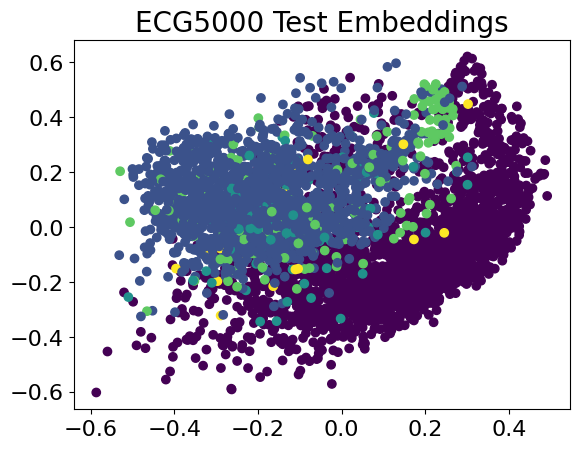

In [12]:
from sklearn.decomposition import PCA

test_embeddings_manifold = PCA(n_components=2).fit_transform(test_embeddings) 

plt.title(f"ECG5000 Test Embeddings", fontsize=20)
plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze()
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### 4.5 Results Interpretation 
#### MOMENT Learns Meaningful Representations without Dataset-specific Fine-tuning

Here we can see that the first two principal components of the representations that MOMENT is learning can distinguish normal and abnormal heartbeats denoted by different colors. This can explain MOMENT + SVM's promising classification accuracy. Note that these represenations are learnt zero-shot. Even without dataset-specific fine-tuning, MOMENT learns distinct representations of different classes of heartbeats.

### 4.6 Fully Supervised Learning using Classification Head


We can also perform classification by attaching a randomly-initialized classification head to MOMENT and fine-tuning it. Here's an example code to fine-tune MOMENT with a classification head:

```python

# Remember MOMENT must be initialized in `classification` mode
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'classification',
        'n_channels': 1,
        'num_class': 5
    },
)

# Define a data loader 
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for data, labels in train_dataloader:
    # forward [batch_size, n_channels, forecast_horizon]
    output = model(data)

    # backward
    loss = criterion(output.logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"loss: {loss.item():.3f}")
```